## Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from keras.models import load_model
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc
%matplotlib inline


In [2]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.10.1
2.10.0
1.26.4


## Load the dataset & Preprocessing

In [3]:
train_path='Preprocessed Data/train'
valid_path='Preprocessed Data/valid'
test_path='Preprocessed Data/test'

In [4]:
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=20)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path,target_size=(224,224),batch_size=20)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=20,shuffle=False)

Found 318 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## Define & Customize pre-trained MobileNet model 

In [5]:
mobile1=keras.applications.mobilenet.MobileNet()

In [6]:
mobile1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_4_bn (BatchNormaliz  (None, 28, 28, 256)      1024      
 ation)                                                          
                                                                 
 conv_pw_4_relu (ReLU)       (None, 28, 28, 256)       0         
                                                                 
 conv_dw_5 (DepthwiseConv2D)  (None, 28, 28, 256)      2304      
                                                                 
 conv_dw_5_bn (BatchNormaliz  (None, 28, 28, 256)      1024      
 ation)                                                          
                                                                 
 conv_dw_5_relu (ReLU)       (None, 28, 28, 256)       0         
                                                                 
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)       65536     
                                                                 
 conv_pw_5

In [7]:
mobile1.output_shape

(None, 1000)

#### Build a new model that consist of the original MobileNet up to the fifth to last layer

In [8]:
x = mobile1.layers[-5].output

#### reshape output.shape from last layer and add output layer

In [9]:
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
predictions=Dense(2,activation='sigmoid')(x)
model=Model(inputs=mobile1.input,outputs=predictions)

In [10]:
model.output_shape

(None, 2)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

 conv_pw_10 (Conv2D)         (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_10_bn (BatchNormali  (None, 14, 14, 512)      2048      
 zation)                                                         
                                                                 
 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)       0         
                                                                 
 conv_dw_11 (DepthwiseConv2D  (None, 14, 14, 512)      4608      
 )                                                               
                                                                 
 conv_dw_11_bn (BatchNormali  (None, 14, 14, 512)      2048      
 zation)                                                         
                                                                 
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)       0         
                                                                 
 conv_pw_1

#### freezing the weights

In [12]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Train The Model

### compile the model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

#### add early stopping callback

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

#### fit the model

In [16]:
len(train_batches)

16

In [17]:
len(valid_batches)

6

In [18]:
history = model.fit_generator(train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=10,verbose=2, callbacks=[early_stopping])

C:\Users\Chath\AppData\Local\Temp\ipykernel_3556\3494267884.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=10,verbose=2, callbacks=[early_stopping])


Epoch 1/10


c:\Users\Chath\anaconda3\envs\Dilshi_Research\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 - 20s - loss: 0.7414 - accuracy: 0.4748 - val_loss: 0.7498 - val_accuracy: 0.4667 - 20s/epoch - 1s/step
Epoch 2/10
16/16 - 18s - loss: 0.7192 - accuracy: 0.5157 - val_loss: 0.7332 - val_accuracy: 0.5083 - 18s/epoch - 1s/step
Epoch 3/10
16/16 - 18s - loss: 0.7041 - accuracy: 0.5535 - val_loss: 0.7194 - val_accuracy: 0.5167 - 18s/epoch - 1s/step
Epoch 4/10
16/16 - 18s - loss: 0.6910 - accuracy: 0.5755 - val_loss: 0.7057 - val_accuracy: 0.5500 - 18s/epoch - 1s/step
Epoch 5/10
16/16 - 18s - loss: 0.6778 - accuracy: 0.6006 - val_loss: 0.6935 - val_accuracy: 0.5833 - 18s/epoch - 1s/step
Epoch 6/10
16/16 - 18s - loss: 0.6659 - accuracy: 0.6289 - val_loss: 0.6822 - val_accuracy: 0.5917 - 18s/epoch - 1s/step
Epoch 7/10
16/16 - 18s - loss: 0.6539 - accuracy: 0.6352 - val_loss: 0.6703 - val_accuracy: 0.5917 - 18s/epoch - 1s/step
Epoch 8/10
16/16 - 18s - loss: 0.6425 - accuracy: 0.6604 - val_loss: 0.6604 - val_accuracy: 0.6667 - 18s/epoch - 1s/step
Epoch 9/10
16/16 - 23s - loss: 0.6314 - acc

#### test accuracy

In [19]:
loss, acc = model.evaluate(test_batches)

1/1 [==============================] - 1s 1s/step - loss: 0.6407 - accuracy: 0.6000


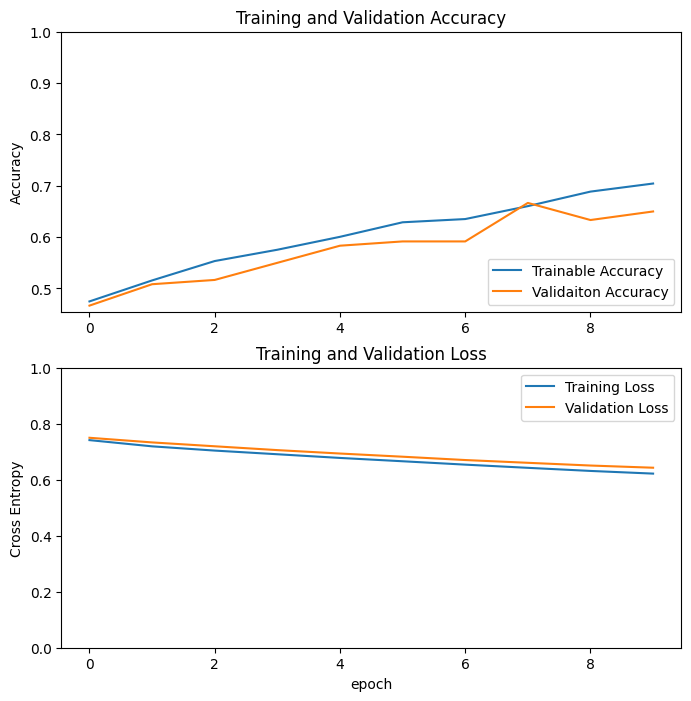

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Trainable Accuracy')
plt.plot(val_acc, label='Validaiton Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [21]:
# Setting the top layer as trainable
mobile1.trainable = True

In [22]:
ft_model = mobile1.layers[-5].output
ft_model = tf.keras.layers.Reshape(target_shape=(1024,))(ft_model)
predictions=Dense(2,activation='sigmoid')(ft_model)
ft_model=Model(inputs=mobile1.input,outputs=predictions)

In [23]:
print('Number of layers in the base model: ', len(ft_model.layers))

Number of layers in the base model:  89


In [24]:
# Fine-tune from this layer onwards 
fine_tune_at = 60


# Freeze all the layers before the `fine_tune_at` layer
for layer in ft_model.layers[:fine_tune_at]:
    layer.trainable = False

In [41]:
ft_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

c:\Users\Chath\anaconda3\envs\Dilshi_Research\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [42]:
ft_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [43]:
# Printing the no. of trainable_variables of the model
len(model.trainable_variables)

26

#### Continue training the model

In [44]:
history_fine   = ft_model.fit_generator(train_batches,steps_per_epoch=len(train_batches), validation_data=valid_batches,validation_steps=len(valid_batches), epochs=20, initial_epoch=history.epoch[-1], verbose=2, callbacks=[early_stopping])

C:\Users\Chath\AppData\Local\Temp\ipykernel_3556\3921286146.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine   = ft_model.fit_generator(train_batches,steps_per_epoch=len(train_batches), validation_data=valid_batches,validation_steps=len(valid_batches), epochs=20, initial_epoch=history.epoch[-1], verbose=2, callbacks=[early_stopping])


Epoch 10/20


c:\Users\Chath\anaconda3\envs\Dilshi_Research\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 - 32s - loss: 0.1364 - accuracy: 0.9623 - val_loss: 1.5678 - val_accuracy: 0.6833 - 32s/epoch - 2s/step
Epoch 11/20
16/16 - 29s - loss: 0.0663 - accuracy: 0.9780 - val_loss: 0.3334 - val_accuracy: 0.9583 - 29s/epoch - 2s/step
Epoch 12/20
16/16 - 40s - loss: 0.0779 - accuracy: 0.9811 - val_loss: 3.4511 - val_accuracy: 0.5833 - 40s/epoch - 2s/step
Epoch 13/20
16/16 - 39s - loss: 0.0300 - accuracy: 0.9843 - val_loss: 0.1498 - val_accuracy: 0.9667 - 39s/epoch - 2s/step
Epoch 14/20
16/16 - 30s - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.3084 - val_accuracy: 0.9667 - 30s/epoch - 2s/step
Epoch 15/20
16/16 - 31s - loss: 0.0776 - accuracy: 0.9717 - val_loss: 0.0989 - val_accuracy: 0.9583 - 31s/epoch - 2s/step
Epoch 16/20
16/16 - 31s - loss: 0.0494 - accuracy: 0.9843 - val_loss: 0.8434 - val_accuracy: 0.8917 - 31s/epoch - 2s/step
Epoch 17/20
16/16 - 26s - loss: 0.0810 - accuracy: 0.9874 - val_loss: 8.0092 - val_accuracy: 0.5000 - 26s/epoch - 2s/step
Epoch 18/20
16/16 - 27s - loss: 0.01

In [45]:
ft_model.evaluate(test_batches)

1/1 [==============================] - 1s 997ms/step - loss: 0.0037 - accuracy: 1.0000


[0.003729200456291437, 1.0]

In [55]:
# acc_ft= history_fine.history['accuracy']
# val_acc_ft= history_fine.history['val_accuracy']

# loss_ft= history_fine.history['loss']
# val_loss_ft= history_fine.history['val_loss']

# plt.figure(figsize=(8,8))
# plt.subplot(2,1,1)
# plt.plot(acc_ft, label='Trainable Accuracy')
# plt.plot(val_acc_ft, label='Validaiton Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([0.4, 1.1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss_ft, label='Training Loss')
# plt.plot(val_loss_ft, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0, 1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

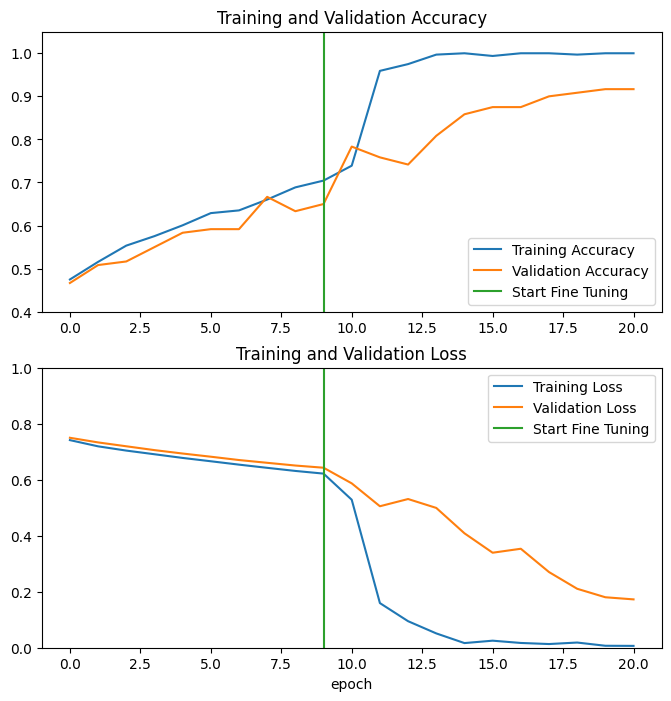

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.05])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save the fine tune model

In [33]:
# ft_model.save(filepath="save_model/")

# Model evaluation

#### show test images

In [47]:
def plotImages(images_arr):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

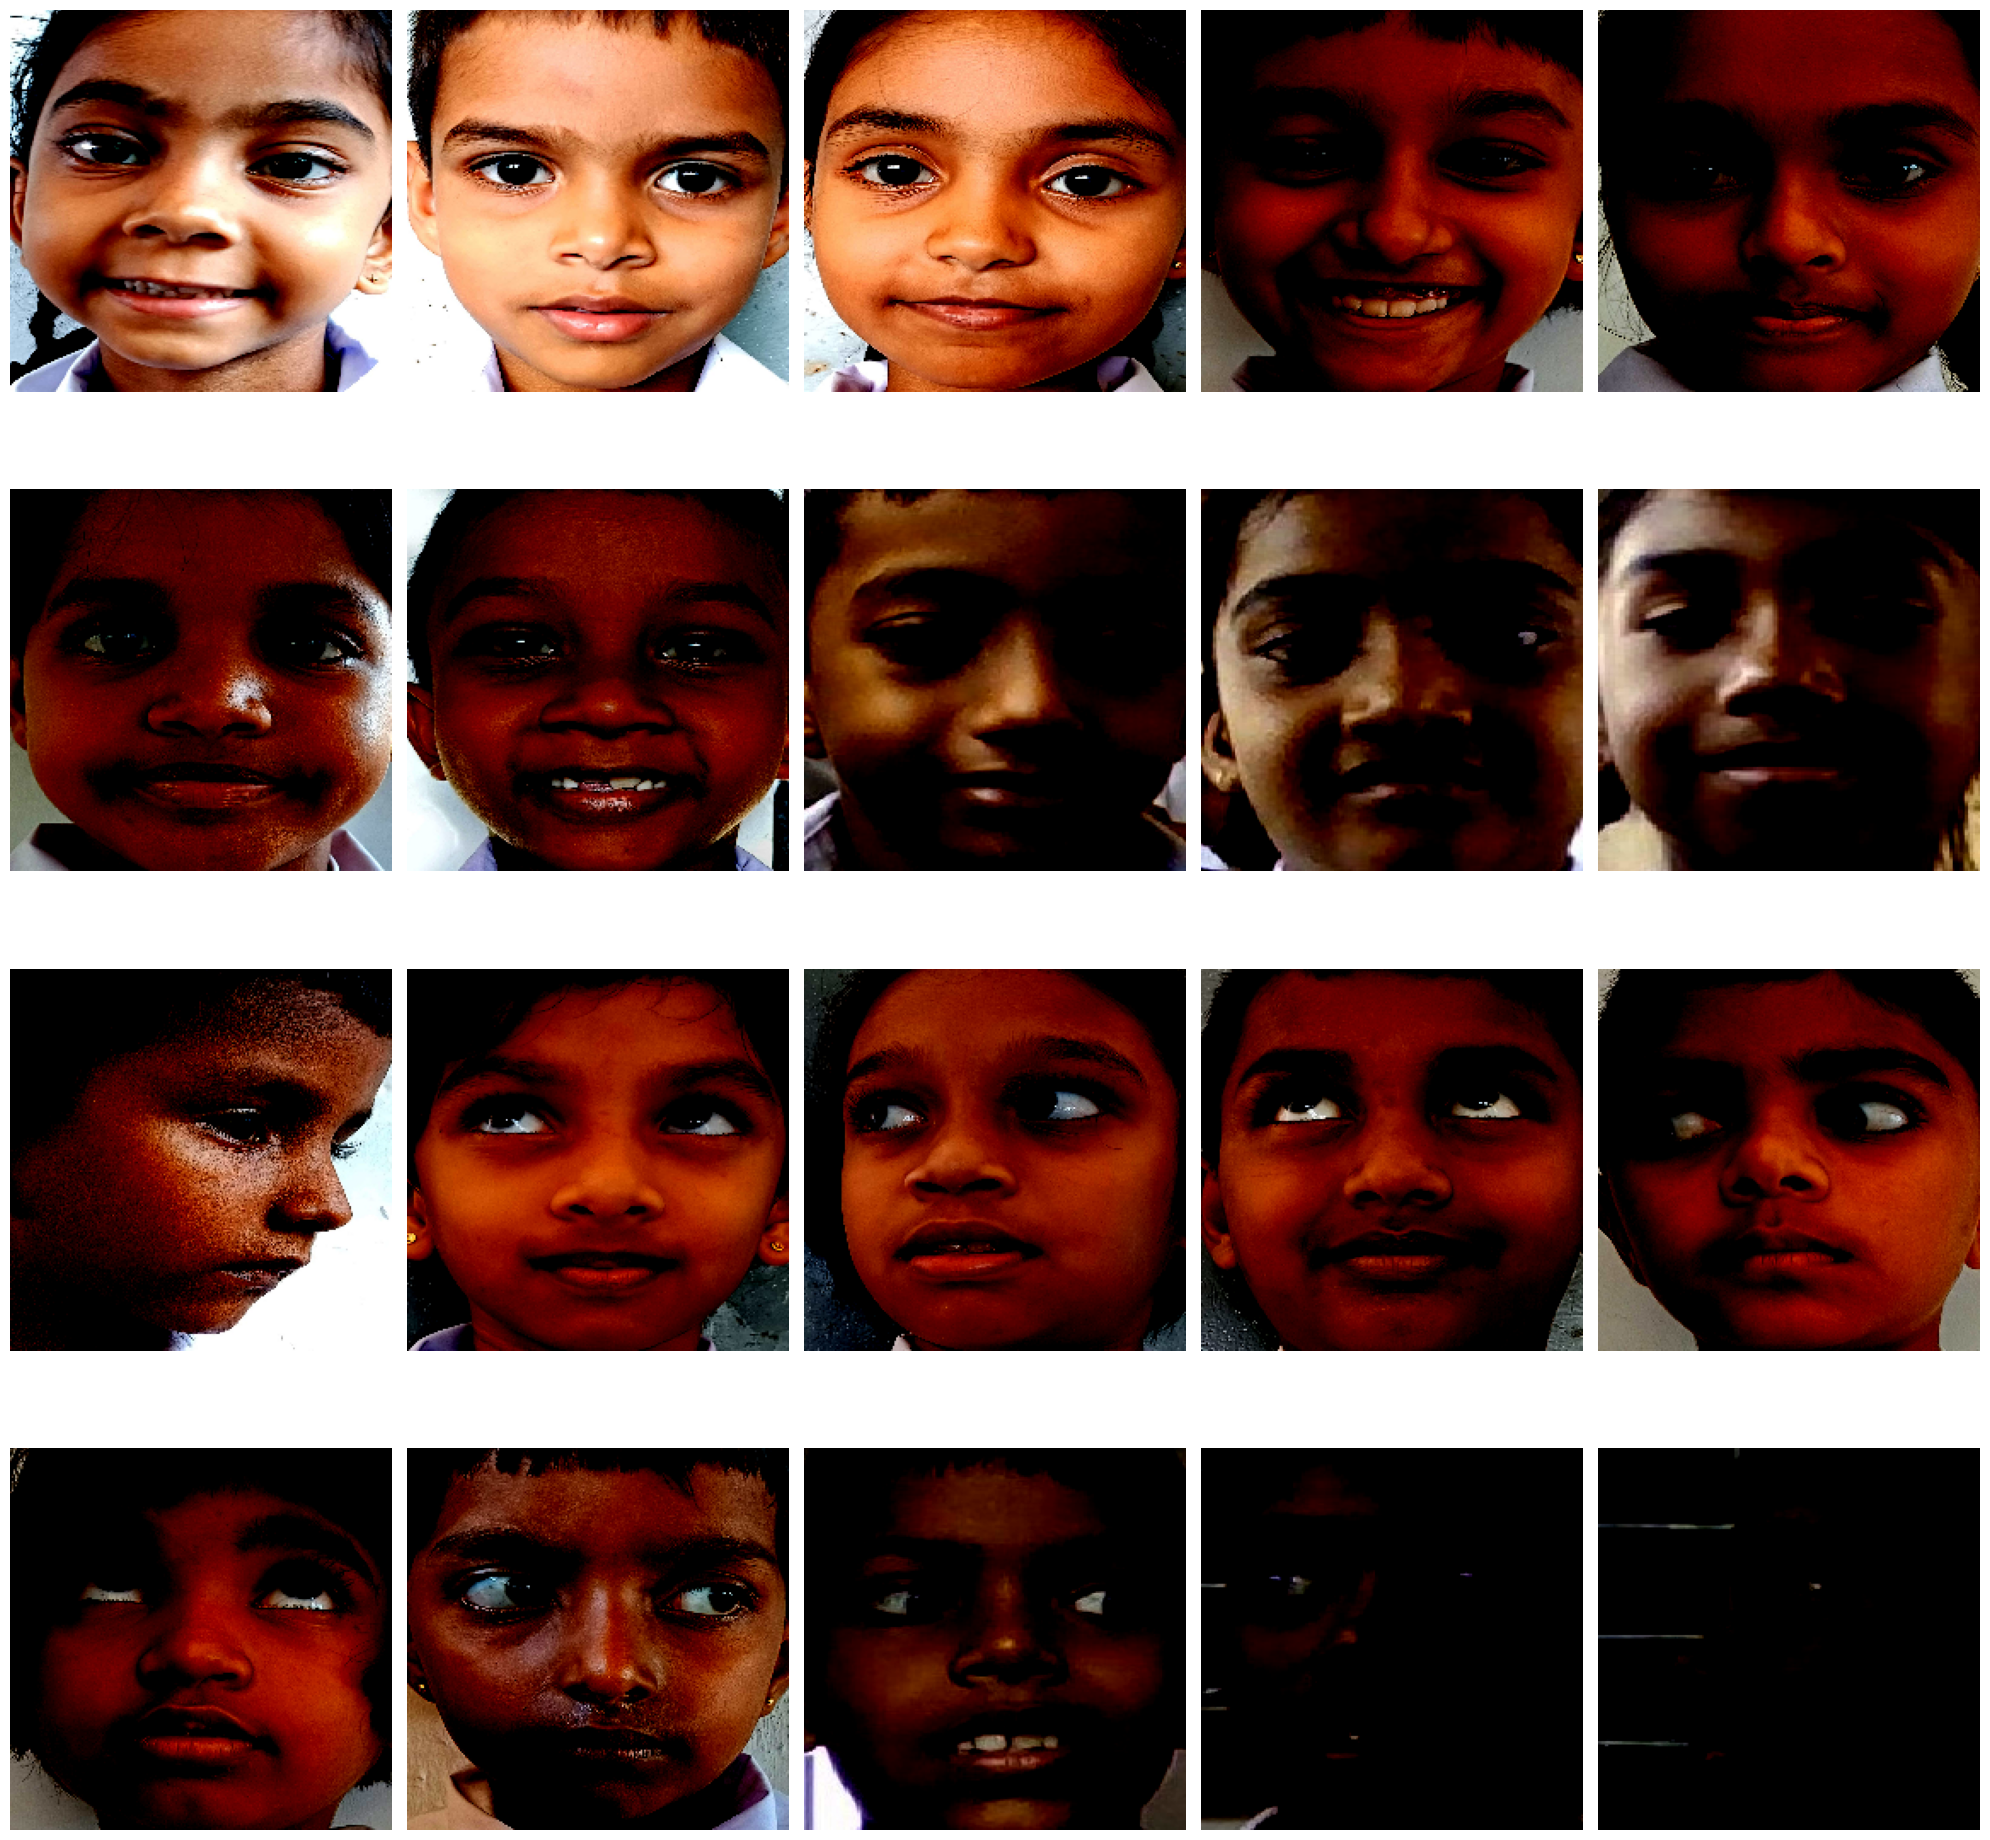

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [48]:
test_imgs,test_labels=next(test_batches)
plotImages(test_imgs)
print(test_labels)

#### predict the classes of test images

In [49]:
test_batches.class_indices

{'attention': 0, 'not_attention': 1}

In [50]:
predictions=ft_model.predict(x=test_batches,verbose=0)
np.argmax(predictions,axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

### confusion_matrix

In [51]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


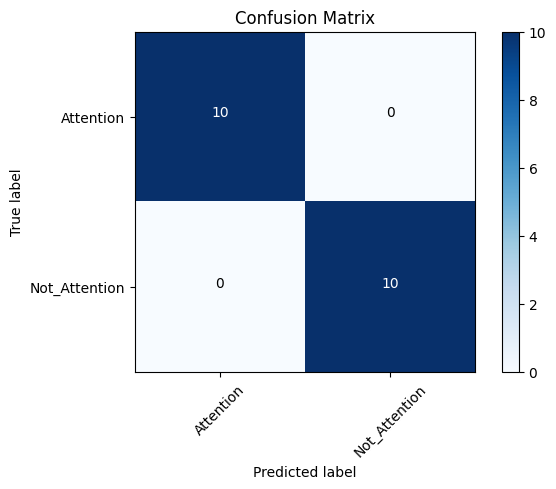

In [53]:
cm_plot_labels=['Attention','Not_Attention']

plt.figure()
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')